In [1]:
# TODO:add argument system to change experiment condition for structure expolation and do experiments for paper
import os
import numbers

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid, save_image

print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
can_use_gpu = torch.cuda.is_available()
print('Is GPU available:', can_use_gpu)

PyTorch version: 1.0.0
torchvision version: 0.2.1
Is GPU available: True


In [2]:
# general settings

device = torch.device('cuda' if can_use_gpu else 'cpu')

batchsize_train = 64
batchsize_validation = 5 # this also means the number of images saved in every interval epoch.

height_for_train_cropping = 128
width_for_train_cropping = 128
height_for_validation_cropping = 768
width_for_validation_cropping = 512

# TODO:seed setting and exclude randomness?

# directory settings
root_dir = '../../data/komonjo_experiment/200003076/'

# training data directory
image_dir = root_dir + 'training_data/images_resized_quarter/'
label_dir = root_dir + 'training_data/one_hot_xw0.8_h0.5_resized_quarter/'

result_dir = root_dir + 'experiment_result/'
conducted_experiment_name_list = sorted(os.listdir(result_dir))
new_experiment_name = 'experiment_%03d' % (int(conducted_experiment_name_list[-1].split('_')[1])+1)
new_experiment_dir = result_dir + new_experiment_name + '/'
os.mkdir(new_experiment_dir)

# directory to save model output
result_image_dir = new_experiment_dir + 'result_image/'
if not os.path.exists(result_image_dir):
    os.mkdir(result_image_dir)

# directory to save model weights and training log
log_dir = new_experiment_dir + 'trained_weights_and_training_log/'
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
    
experiment_condition_txt = new_experiment_dir + 'experiment_condition.txt'
with open(experiment_condition_txt, 'a') as f:
    f.write('{} condition\n\n'.format(new_experiment_name))
    f.write('PyTorch version : {}\n'.format(torch.__version__))
    f.write('torchvision version : {}\n\n'.format(torchvision.__version__))
    f.write('training batchsize : {}\n'.format(batchsize_train))
    f.write('training crop size : {}\n'.format((height_for_train_cropping, width_for_train_cropping)))
    f.write('validation crop size : {}\n\n'.format((height_for_validation_cropping, width_for_validation_cropping)))
    f.write('used image dataset : {}\n'.format(image_dir))
    f.write('used label dataset : {}\n\n'.format(label_dir))

In [3]:
class DocDataset(Dataset):
    def __init__(self, image_dir, label_dir, file_name_list,
                 transform_sync=None, transform_image=None, transform_label=None):
        assert(image_dir[-1] == '/')
        assert(label_dir[-1] == '/')
        self.image_dir = image_dir
        self.label_dir = label_dir
        
        # image or label filename list in image_dir or label_dir (to speedup train_test_split, I'll split file name list)
        # I expect corresponding image and label have same filename
        # This sort is so that following __getitem__ method expect file_name_list have unique order
        self.file_name_list = sorted(file_name_list) 
        
        # to do same random cropping for corresponding image and label
        self.transform_sync = transform_sync
        self.transform_image = transform_image
        self.transform_label = transform_label
        
    def __len__(self):
        return len(self.file_name_list)
    
    def __getitem__(self, idx):
        image_name = self.image_dir + self.file_name_list[idx]
        label_name = self.label_dir + self.file_name_list[idx]
        label_name = label_name.replace('.jpg', '.png')
        
        image = Image.open(image_name)
        label = Image.open(label_name)
        
        if self.transform_sync is not None:
            image, label = self.transform_sync(image, label)
        if self.transform_image is not None:
            image = self.transform_image(image)
        if self.transform_label is not None:
            label = self.transform_label(label) 
            
        return image, label

In [4]:
# split to train data and validation data for simplicity
# TODO:test should be conducted by isolated test data (different document)

# sort to eliminate os.listdir randomness
# I expect corresponding image and label have same filename
file_name = sorted(os.listdir(image_dir))
train_file_name, validation_file_name = train_test_split(file_name, test_size=0.2)

print('The number of training data:', len(train_file_name))
print('The number of validation data:', len(validation_file_name))

with open(experiment_condition_txt, 'a') as f:
    f.write('The number of training data : {}\n'.format(len(train_file_name)))
    f.write('The number of validation data : {}\n\n'.format(len(validation_file_name)))

The number of training data: 276
The number of validation data: 70


In [5]:
# transform for synchronize cropping for image and label
# warning:this class can't do padding
class RandomCropSync(object):
    def __init__(self, size):
        if isinstance(self, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
    
    def get_params(self, img, output_size):
        w, h = img.size
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w
        
        i = np.random.randint(0, h - th)
        j = np.random.randint(0, w - tw)
        return i, j, th, tw
    
    def __call__(self, img1, img2):
        assert(img1.size == img2.size)
        i, j, h, w = self.get_params(img1, self.size)
        
        img1_cropped = torchvision.transforms.functional.crop(img1, i, j, h, w)
        img2_cropped = torchvision.transforms.functional.crop(img2, i, j, h, w)
        
        return img1_cropped, img2_cropped

In [6]:
tf_sync_train = RandomCropSync((height_for_train_cropping, width_for_train_cropping))
tf_image_train = transforms.ToTensor()
tf_label_train = transforms.ToTensor()
tf_image_validation = transforms.Compose([transforms.CenterCrop((height_for_validation_cropping,
                                                                 width_for_validation_cropping)), transforms.ToTensor()])
tf_label_validation = transforms.Compose([transforms.CenterCrop((height_for_validation_cropping, 
                                                                 width_for_validation_cropping)), transforms.ToTensor()])

train_dataset = DocDataset(image_dir, label_dir, train_file_name,
                           tf_sync_train, tf_image_train, tf_label_train)
validation_dataset = DocDataset(image_dir, label_dir, validation_file_name,
                                None, tf_image_validation, tf_label_validation)

train_loader = DataLoader(train_dataset, batch_size=batchsize_train, shuffle=True)
# In validation, I'll save estimated label, therefore shuffle=True to save result for different input
validation_loader = DataLoader(validation_dataset, batch_size=batchsize_validation, shuffle=True)

with open(experiment_condition_txt, 'a') as f:
    f.write('transform sync(image and label) for train : {}\n'.format(tf_sync_train))
    f.write('transform image for train : {}\n'.format(tf_image_train))
    f.write('transform label for train : {}\n'.format(tf_label_train))
    f.write('transform image for validation : {}\n'.format(tf_image_validation))
    f.write('transform label for validation : {}\n\n'.format(tf_label_validation))

In [7]:
# TODO:explore other normalization
# define parts for U-net for convenience (for encoder parts)
# downsampling to half size (default)
# conv > batchnorm(optional) > dropout(optional) > relu
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, ksize=4, stride=2, padding=1, use_bn=True, drop_prob=0.0):
        super(DownSample, self).__init__()
        self.use_batchnorm = use_bn
        self.use_dropout = drop_prob > 0
        
        self.cv = nn.Conv2d(in_channels, out_channels, kernel_size=ksize, stride=stride, padding=padding)
        if self.use_batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)
        if self.use_dropout:
            self.dr = nn.Dropout(drop_prob)
        self.rl = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        out = self.cv(x)
        if self.use_batchnorm:
            out = self.bn(out)
        if self.use_dropout:
            out = self.dr(out)
        out = self.rl(out)
        return out

In [8]:
# TODO:explore other normalization (because batch size is very small)
# define parts for U-net for convenience (for decorder)
# upsampling to double size (default) (using transposed convolution)
# conv > batchnorm(optional) > dropout(optional) > relu
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, ksize=4, stride=2, padding=1, use_bn=True, drop_prob=0.0):
        super(UpSample, self).__init__()
        self.use_batchnorm = use_bn
        self.use_dropout = drop_prob > 0
        
        self.tc = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=ksize, stride=stride, padding=padding)
        if self.use_batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)
        if self.use_dropout:
            self.dr = nn.Dropout(drop_prob)
        self.rl = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out = self.tc(x)
        if self.use_batchnorm:
            out = self.bn(out)
        if self.use_dropout:
            out = self.dr(out)
        out = self.rl(out)
        return out

In [9]:
# TODO : add attribute for switching using dropout or not and batchnorm or not
class U_Net(nn.Module):
    def __init__(self, n_depth_encoder, n_base_channels=32):
        super(U_Net, self).__init__()
        
        self.n_depth_encoder = n_depth_encoder
        n_channels = 3
        max_channels = 1024
        
        # encoder parts
        self.encoder = nn.ModuleList()
        for i in range(self.n_depth_encoder):
            if i == 0:
                n_in_channels = min(n_channels, max_channels)
                n_out_channels = min(n_base_channels, max_channels)
                self.encoder.append(DownSample(n_in_channels, n_out_channels, use_bn=False))
                n_channels = n_base_channels
            else:
                n_in_channels = min(n_channels, max_channels)
                n_out_channels = min(n_channels*2, max_channels)
                self.encoder.append(DownSample(n_in_channels, n_out_channels))
                n_channels = n_channels*2
                
        # decoder parts
        self.decoder = nn.ModuleList()
        for i in range(self.n_depth_encoder):
            if i == 0:
                n_in_channels = min(n_channels, max_channels)
                n_out_channels = min(n_channels, max_channels)
                self.decoder.append(UpSample(n_in_channels, n_out_channels))
            else:
                n_in_channels = min(n_channels, max_channels) + min(n_channels//2, max_channels)
                n_out_channels = min(n_channels//2, max_channels)
                self.decoder.append(UpSample(n_in_channels, n_out_channels))
                n_channels = n_channels//2

        # 1x1 convolution to adjust channels and refine result
        self.conv1x1 = nn.Sequential(
                            nn.Conv2d(n_channels, n_channels//2, kernel_size=1, stride=1, padding=0),
                            nn.BatchNorm2d(n_channels // 2),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(n_channels//2, 3, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        out_encoders = []
        for i in range(self.n_depth_encoder):
            if i != 0:
                out_encoders.append(x)
            x = self.encoder[i](x)
            
        for i in range(self.n_depth_encoder):
            if i == 0:
                x = self.decoder[i](x)
            else:
                concated_input = torch.cat([x, out_encoders[self.n_depth_encoder-i-1]], dim=1)
                x = self.decoder[i](concated_input)
        
        out = self.conv1x1(x)
        return out

In [10]:
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True, ignore_index=255):
        super(CrossEntropyLoss2d, self).__init__()
        self.bce_loss = nn.BCELoss(weight, size_average)

    def forward(self, inputs, targets):
        return self.bce_loss(F.log_softmax(inputs, dim=1), targets)

In [11]:
net = U_Net(n_depth_encoder=7, n_base_channels=128)
net = net.to(device)

#TODO:explore good initialization

optimizer = optim.Adam(net.parameters(), lr=5e-4)
# criterion = CrossEntropyLoss2d()
criterion = nn.BCEWithLogitsLoss()

# count the number of trainable parameters
num_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

# print settings
print('The number of trainable parameters:', num_trainable_params)
print('Model:\n', net)
print('\nOptimizer:\n', optimizer)
print('Loss:\n', criterion)

with open(experiment_condition_txt, 'a') as f:
    f.write('The number of trainable parameters : {}\n'.format(num_trainable_params))
    f.write('Model : \n{}\n\n'.format(net))
    f.write('Optimizer : \n{}\n\n'.format(optimizer))
    f.write('Loss : {}\n\n'.format(criterion))

The number of trainable parameters: 195341699
Model:
 U_Net(
  (encoder): ModuleList(
    (0): DownSample(
      (cv): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (rl): LeakyReLU(negative_slope=0.2)
    )
    (1): DownSample(
      (cv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): LeakyReLU(negative_slope=0.2)
    )
    (2): DownSample(
      (cv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): LeakyReLU(negative_slope=0.2)
    )
    (3): DownSample(
      (cv): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): LeakyReLU(negative_slope=0.2)
    )
    (4): DownSample(
      (cv): Conv2d

In [12]:
def train(data_loader):
    net.train()
    running_loss = 0
    
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    average_loss = running_loss / len(data_loader)
    return average_loss

In [13]:
def validation(data_loader, epoch):
    net.eval()
    interval_save_images_epoch = 5
    running_loss = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = net(inputs)
            
            running_loss += criterion(outputs, labels).item()
        average_loss = running_loss / len(data_loader)
        
    # TODO:save experiment condition with result image name or separated config.json
    # save image like (input, output, label) style for comparison
    # use final minibatch
    if epoch % interval_save_images_epoch == 0:
        for i in range(batchsize_validation):
            # unsqueeze to concat
            input_image = inputs[i].unsqueeze(0)
            
            # expands to 3 channels to concat with input image
            output_image = outputs[i].expand(3, *outputs[i].size()[1:]).unsqueeze(0)
            label_image = labels[i].expand(3, *labels[i].size()[1:]).unsqueeze(0)
            
            # save image internally use make_grid and convert image like [3, 3, height, width] -> [3, height, width*3]
            comparison_image = torch.cat([input_image, output_image, label_image])
            save_image(comparison_image.data.cpu(), '{}input_output_GT_{}_{}.png'.format(result_image_dir, epoch, i))
    
    return average_loss

In [ ]:
n_epochs = 500
train_loss_list = []
validation_loss_list = []

for epoch in range(n_epochs):
    train_loss = train(train_loader)
    validation_loss = validation(validation_loader, epoch)
    
    train_loss_list.append(train_loss)
    validation_loss_list.append(validation_loss)
    
    print('epoch[%2d/%2d] train_loss:%1.4f validation_loss:%1.4f' % (epoch+1, n_epochs, train_loss, validation_loss))

# TODO:save experiment condition with weight and log filename or separated config.json
# save state dicts
torch.save(net.state_dict(), log_dir + 'weight_' + str(epoch+1) + '.pth')

# save learning log
np.save(log_dir + 'train_loss_list.npy', np.array(train_loss_list))
np.save(log_dir + 'validation_loss_list.npy', np.array(validation_loss_list))

epoch[ 1/500] train_loss:0.6802 validation_loss:0.7057
epoch[ 2/500] train_loss:0.6225 validation_loss:0.8896
epoch[ 3/500] train_loss:0.5949 validation_loss:0.6621
epoch[ 4/500] train_loss:0.5760 validation_loss:1.1776
epoch[ 5/500] train_loss:0.5587 validation_loss:0.7201
epoch[ 6/500] train_loss:0.5446 validation_loss:0.5916
epoch[ 7/500] train_loss:0.5316 validation_loss:0.6725
epoch[ 8/500] train_loss:0.5198 validation_loss:0.5738
epoch[ 9/500] train_loss:0.5077 validation_loss:0.5660
epoch[10/500] train_loss:0.4940 validation_loss:0.5647
epoch[11/500] train_loss:0.4807 validation_loss:0.5224
epoch[12/500] train_loss:0.4688 validation_loss:0.5778
epoch[13/500] train_loss:0.4551 validation_loss:0.4704
epoch[14/500] train_loss:0.4434 validation_loss:0.4259
epoch[15/500] train_loss:0.4309 validation_loss:0.4375
epoch[16/500] train_loss:0.4187 validation_loss:0.4026
epoch[17/500] train_loss:0.4050 validation_loss:0.3951
epoch[18/500] train_loss:0.3943 validation_loss:0.3727
epoch[19/5

epoch[150/500] train_loss:0.0474 validation_loss:0.0395
epoch[151/500] train_loss:0.0459 validation_loss:0.0401
epoch[152/500] train_loss:0.0473 validation_loss:0.0367
epoch[153/500] train_loss:0.0467 validation_loss:0.0418
epoch[154/500] train_loss:0.0456 validation_loss:0.0384
epoch[155/500] train_loss:0.0466 validation_loss:0.0513
epoch[156/500] train_loss:0.0439 validation_loss:0.0394
epoch[157/500] train_loss:0.0421 validation_loss:0.0373
epoch[158/500] train_loss:0.0439 validation_loss:0.0385
epoch[159/500] train_loss:0.0437 validation_loss:0.0465
epoch[160/500] train_loss:0.0464 validation_loss:0.0496
epoch[161/500] train_loss:0.0449 validation_loss:0.0564
epoch[162/500] train_loss:0.0444 validation_loss:0.0555
epoch[163/500] train_loss:0.0459 validation_loss:0.0380
epoch[164/500] train_loss:0.0450 validation_loss:0.0470
epoch[165/500] train_loss:0.0450 validation_loss:0.0454
epoch[166/500] train_loss:0.0451 validation_loss:0.0358
epoch[167/500] train_loss:0.0463 validation_loss

epoch[297/500] train_loss:0.0329 validation_loss:0.0390
epoch[298/500] train_loss:0.0314 validation_loss:0.0260
epoch[299/500] train_loss:0.0328 validation_loss:0.0317
epoch[300/500] train_loss:0.0348 validation_loss:0.0280
epoch[301/500] train_loss:0.0332 validation_loss:0.0320
epoch[302/500] train_loss:0.0353 validation_loss:0.0254
epoch[303/500] train_loss:0.0336 validation_loss:0.1581
epoch[304/500] train_loss:0.0317 validation_loss:0.0381
epoch[305/500] train_loss:0.0337 validation_loss:0.0334
epoch[306/500] train_loss:0.0339 validation_loss:0.0251
epoch[307/500] train_loss:0.0329 validation_loss:0.0265
epoch[308/500] train_loss:0.0306 validation_loss:0.0306
epoch[309/500] train_loss:0.0327 validation_loss:0.0304
epoch[310/500] train_loss:0.0335 validation_loss:0.0244
epoch[311/500] train_loss:0.0331 validation_loss:0.0287
epoch[312/500] train_loss:0.0333 validation_loss:0.0283
epoch[313/500] train_loss:0.0338 validation_loss:0.0313
epoch[314/500] train_loss:0.0350 validation_loss

epoch[444/500] train_loss:0.0294 validation_loss:0.0218
epoch[445/500] train_loss:0.0291 validation_loss:0.0220
epoch[446/500] train_loss:0.0286 validation_loss:0.0208
epoch[447/500] train_loss:0.0285 validation_loss:0.0203
epoch[448/500] train_loss:0.0260 validation_loss:0.0208
epoch[449/500] train_loss:0.0292 validation_loss:0.0213
epoch[450/500] train_loss:0.0273 validation_loss:0.0211


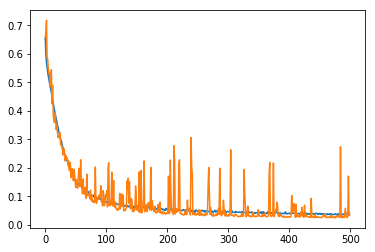

In [70]:
plt.plot(train_loss_list)
plt.plot(validation_loss_list)
plt.show()

In [ ]:
# バッチサイズ64, 学習率5e-4というのが1つのうまく行く組合せらしい（他にもあると思うが、まだ見つけられていない）
# 過学習を起こしている様子はあまりないが、validation lossの安定感に非常に欠ける
# フィルタサイズは大きい方が性能が良い（当然といえば当然） 16とかだとマジで結果が悪い
# 学習率のグラフで結果がたまに跳ね上がることがあるが、それは恐らく絵の画像に突き当たったりしているため